# GRAPHNAME

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/landscape/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/landscape/simulator/'))

In [3]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

from ibm_landscape_processes import *

ibmqfactory.load_account:WARNING:2021-08-30 09:26:33,093: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
%load_ext autoreload
%autoreload 2

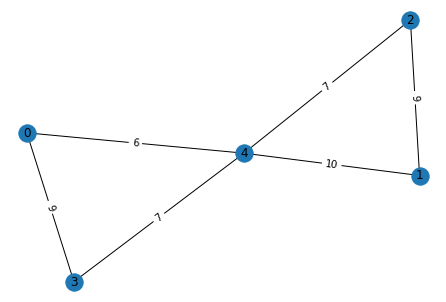

In [13]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=True)
#graph = load_nx_graph_from("graph_3_reg_10_15_w_01.txt")
#graph = load_nx_graph_from("/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/data/graphs/10_nodes/graph_22_01_w.txt")
opt_max_cut = -35
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [14]:
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer

optimal function value: 35.0
optimal value: [0 1 0 1 0]
status: SUCCESS
01010: value: 35.000, probability: 25.0%
01110: value: 33.000, probability: 25.0%
00011: value: 32.000, probability: 25.0%
00101: value: 32.000, probability: 25.0%
Expectation Value: 33.0
Highest Exp.Value: 35 with 25.0 %
Lowest Exp.Value: 32 with 50.0 %
Highest Probability: 32 with 50.0 %
Ratio r: 0.6666666666666666
Approiximation ratio: -0.9428571428571428
MSE: 1.6666666666666667
RMSE: 1.2909944487358056


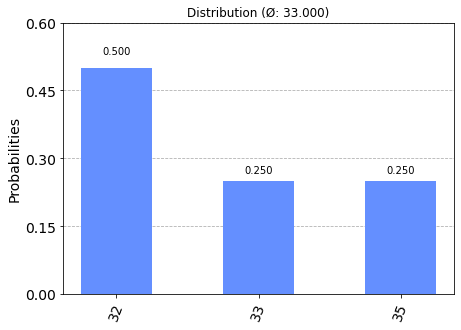

In [16]:
optimizer = GoemansWilliamsonOptimizer(5)
result = optimizer.solve(max_cut_qubo)
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

# Display MaxCut-Landscape for p = 1

In [ ]:
from landscape_helper import *

In [ ]:
landscape = load_landscape_data('landscape_simulator_butterfly_weights_results.npy')

In [ ]:
min_gamma, min_beta, min_exp = describe_landscape(landscape)

In [ ]:
from plot_helper import *

In [ ]:
# Plot landscape in 3D 
plot_landscape_3d(landscape)

In [ ]:
# Plot Heatmap 
heatmap = plot_heatmap(landscape)
heatmap = display_minimum(heatmap, min_gamma, min_beta, min_exp)

### Find init values with TQA

In [11]:
from tqa import calculate_tqa

In [12]:
p = 1

In [13]:
tqa_initial_points = calculate_tqa(graph, p)

TQA: Gamma: [0.45175879], Beta: [0.45175879] (p=1)


#### Run QAOA with init_points, different optimizers and plot results 

In [14]:
from qaoa_helper import *

In [16]:
qnSpsa = QNSPSA(calculate_fidelity(create_qaoa(), max_cut_qubo), maxiter=50)
optimizers = [
    ('COBYLA',COBYLA(maxiter=50)),
    ('SPSA', SPSA(maxiter=50)),
    ('QNSPSA', qnSpsa),
]

COBYLA Optimizer
optimal function value: -35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -28.63125
Highest Exp.Value: 0 with 2.2125 %
Lowest Exp.Value: -35 with 2.2875 %
Highest Probability: -32 with 31.337 %
Ratio r: 0.8180357142857143
Approiximation ratio: 0.8180357142857143
MSE: 134.2253996394231
RMSE: 11.585568593704114


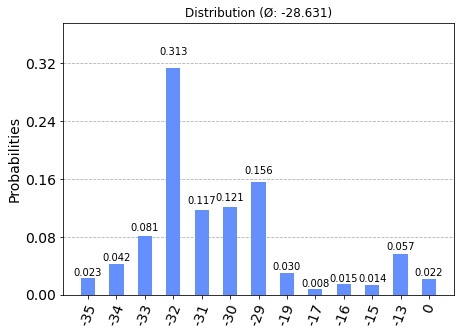


SPSA Optimizer
optimal function value: -35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -23.645875000000004
Highest Exp.Value: 0 with 6.6625000000000005 %
Lowest Exp.Value: -35 with 6.2375 %
Highest Probability: -32 with 16.825000000000003 %
Ratio r: 0.6755964285714287
Approiximation ratio: 0.6755964285714287
MSE: 106.76648143870192
RMSE: 10.332786721823979


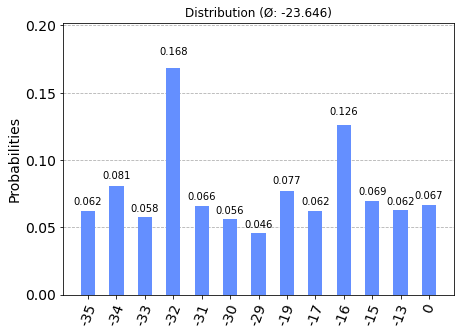


QNSPSA Optimizer
optimal function value: -35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -26.72450000000001
Highest Exp.Value: 0 with 3.8 %
Lowest Exp.Value: -35 with 2.125 %
Highest Probability: -32 with 27.088 %
Ratio r: 0.7635571428571432
Approiximation ratio: 0.7635571428571432
MSE: 117.85305409615391
RMSE: 10.856014650697277


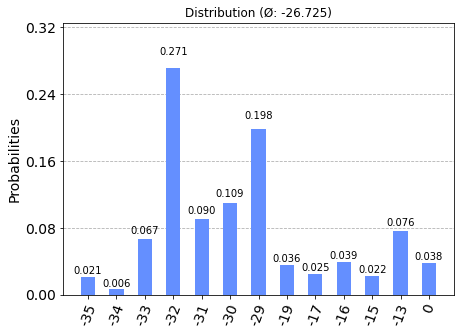

In [17]:
for optimizer_tuple in optimizers:
    optimizer_name, optimizer = optimizer_tuple
    # create qaoa 
    qaoa = create_qaoa(optimizer = optimizer,
            reps=p,
            initial_point=tqa_initial_points,
            with_callback=True
           )
    # run qaoa 
    result, optimal_parameters, optimizer_history = run_qaoa_with_callback(qaoa, max_cut_qubo)
    
    # analyse results 
    print(f"{optimizer_name} Optimizer")
    mean, distribution = max_cut.analyse(result, print_output=True)
    max_cut.plot_histogram(distribution, mean)
    optimizer_history[2][-1] = mean
    print()
    
    # Display Optimizer Results
    # counts, energy_values, maxcut_values, optimizer_gammas, optimizer_betas = optimizer_history
    # display_optimizer_path(heatmap, optimizer_gammas, optimizer_betas, maxcut_values, optimizer_name)
    
    # Plot Optimizer History MaxCut Evaluation # Values from landscape -> real values may deviate 
    # plot_optimizer_maxcut_history(counts, maxcut_values, optimizer_name)
    
    # Plot Optimizer History Energy Evaluation -> not MaxCutMean! 
    # plot_optimizer_energy_history(counts, energy_values, optimizer_name)
    

# Comparision

## Parameters

In [46]:
eval_num = 2
max_p = 2
all_results = {}

## QAOA

In [47]:
from qaoa_helper import *

In [48]:
qaoa_p_means = []
qaoa_p_ratios = []
qaoa_p_approx_ratios = []

for p in range(1,max_p+1):
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p)
    qaoa_p_means.append(m)
    qaoa_p_ratios.append(r)
    qaoa_p_approx_ratios.append(ar)

all_results["QAOA"] = [qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios]

p=1: ..
p=2: ..


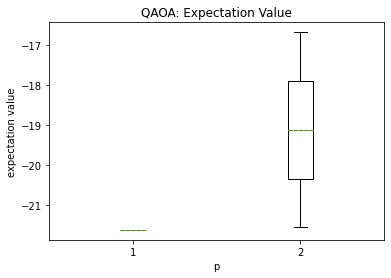

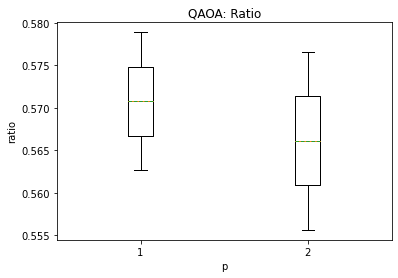

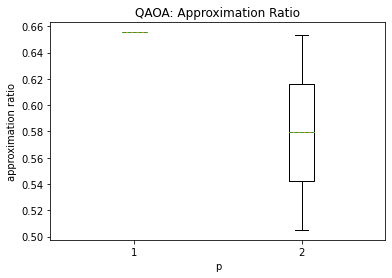

In [49]:
display_boxplots_results(qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios)

## QAOA with TQA

In [50]:
from qaoa_helper import *

In [51]:
tqa_p_means = []
tqa_p_ratios = []
tqa_p_approx_ratios = []
tqa_init_points = []

for p in range(1,max_p+1):
    tqa_initial_points = calculate_tqa(graph, p)
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, init_points=tqa_initial_points)
    tqa_p_means.append(m)
    tqa_p_ratios.append(r)
    tqa_p_approx_ratios.append(ar)
    tqa_init_points.append(tqa_initial_points)
    
all_results["TQA QAOA"] = [tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, tqa_init_points]

..
TQA: Gamma: [0.1986809  0.59604271], Beta: [0.59604271 0.1986809 ] (p=2)
p=2: ..


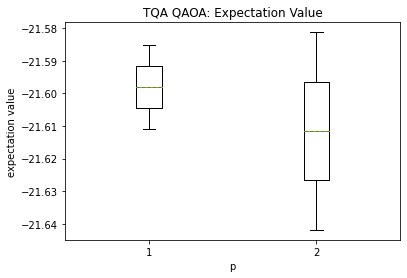

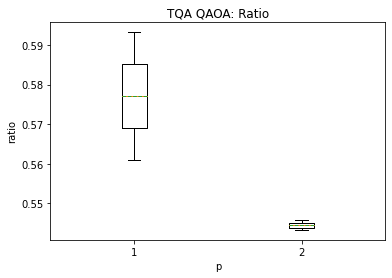

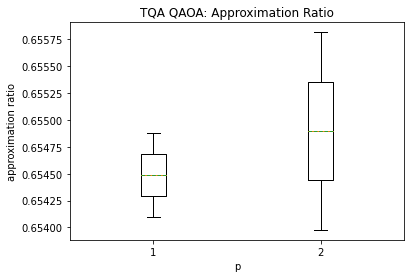

In [52]:
display_boxplots_results(tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, prefix='TQA ')

## WarmStart QAOA

In [ ]:
from warmstart_helper import *

In [ ]:
ws_p_means = []
ws_p_ratios = []
ws_p_approx_ratios = []
ws_opt_epsilons = []

for p in range(1,max_p+1):
    opt_epsilon = optimize_epsilon(max_cut, reps=p)
    m, r, ar = start_ws_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, epsilon=opt_epsilon)
    ws_p_means.append(m)
    ws_p_ratios.append(r)
    ws_p_approx_ratios.append(ar)
    ws_opt_epsilons.append(opt_epsilon)
    
all_results["WarmStart QAOA"] = [ws_p_means, ws_p_ratios, ws_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_p_means, ws_p_ratios, ws_p_approx_ratios, prefix='WarmStart ')

### Recursive QAOA

In [ ]:
# graph nicht lösbar -> Problem muss noch gelöst werden -> class überschreiben und try-catch oder ka? 

In [ ]:
# Hinweis: 
# [done] zweite Metrik hinzufügen 
# [done] bei allen Berechnungen mind. 100 mal ausführen und durchschnitt / median bestimmen -> besser gegen Zufall 
# [done] ratio und Metriken berücksichtigen! die müssen ebenfalls gemittelt werden 
# [done] R-QAOA für QAOA wird einmal mit TQA und einmal mit random werten -> prüfen ob sinnvoll, oder Anfangswerte egal 
# [done] WS-R-QAOA 
# [done] alle Ergebnisse in Tabelle durchschnitts exp. value, ratio, andere in Kopfzeile und danach jeweils die Varianten 
# [done] QAOA ganz am Anfang mit TQA und random werten x mal berechnen. 

# für p > 1 dann selber ablauf, nur ohne plots 

# evaluate function: 
# callback (run qaoa variante) -> wird x mal ausgeführt mit werten und ergebnis wird zurück gegeben. 

In [ ]:
from recursive_qaoa_helper import *

In [ ]:
recursive_p_means = []
recursive_p_ratios = []
recursive_p_approx_ratios = []

for p in range(1,max_p+1):
    m, r, ar = start_recursive_evaluation(max_cut, eval_num=eval_num, reps=p)
    recursive_p_means.append(m)
    recursive_p_ratios.append(r)
    recursive_p_approx_ratios.append(ar)

all_results["Recursive QAOA"] = [recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios]

In [ ]:
display_boxplots_results(recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios, prefix='Recursive ')

### Recursive WarmStart QAOA

In [ ]:
from recursive_ws_helper import *

In [ ]:
ws_recursive_p_means = []
ws_recursive_p_ratios = []
ws_recursive_p_approx_ratios = []

for p in range(1,max_p+1):
    opt_epsilon = ws_opt_epsilons[p-1]
    m, r, ar = start_recursive_ws_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, epsilon=opt_epsilon)
    ws_recursive_p_means.append(m)
    ws_recursive_p_ratios.append(r)
    ws_recursive_p_approx_ratios.append(ar)
    
all_results["Recursive WarmStrart QAOA"] = [ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, prefix='Recursive WarmStart ')

## Results

In [ ]:
from results_helper import *

In [ ]:
means_df, ratio_df, approx_ratios_df = generate_dataframes(all_results)

### Metric Mean

In [ ]:
means_df

### Metric Ratio 

In [ ]:
ratio_df

### Metric Approximation Ratio

In [ ]:
approx_ratios_df

In [ ]:
# Save results 
with open(f'comparison_simulator_{graph.name}_results.npy', 'wb') as f:
    np.save(f, all_results)

In [12]:
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer

optimizer = GoemansWilliamsonOptimizer(5)
result = optimizer.solve(max_cut_qubo)
mean, distribution = max_cut.analyse(result, print_output=True)


Can't solve SDP problem


QiskitOptimizationError: "Inconsistent size of optimal value and variables. x: size 0 [], variables: size 5 ['x_0', 'x_1', 'x_2', 'x_3', 'x_4']"